### **Testing according to the AI Pipeline**

1) DRR + Mask Dataset Loading

In [1]:
from drr_dataset_loading import DRRSegmentationDataset

In [3]:
dataset = DRRSegmentationDataset(
    root_dir='../../../DRR dataset/LIDC_LDRI',
    image_size=(512, 512)
)

torch.Size([4, 1, 512, 512])
torch.Size([4, 1, 512, 512])


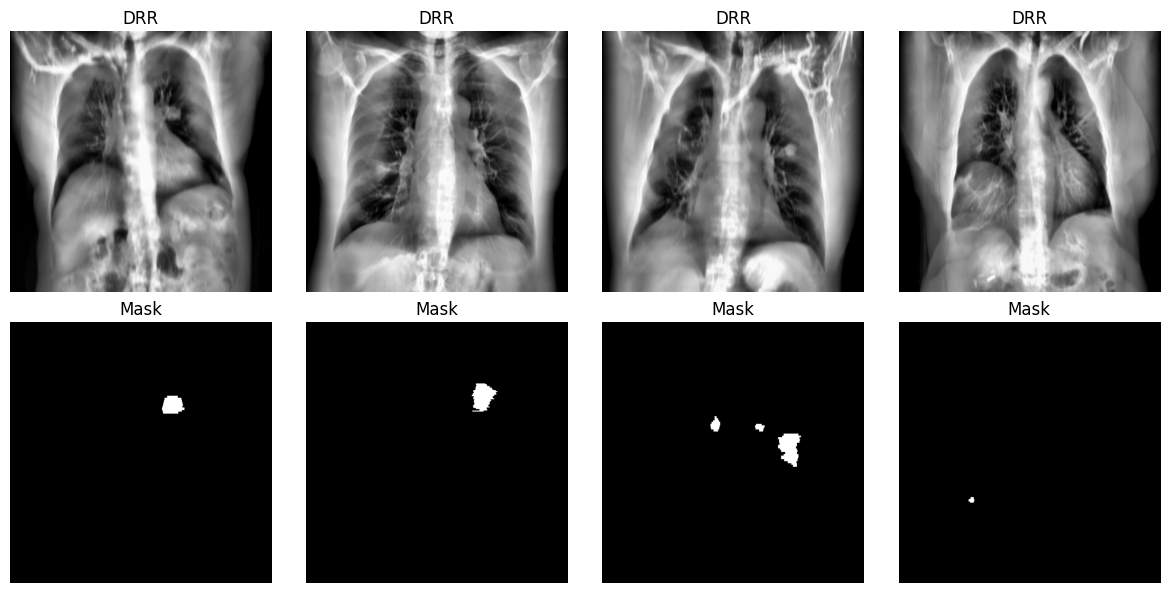

In [4]:
# Following code block is for displaying purpose only. (No need to run unless you want to see a batch of the dataset)

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# DataLoader
loader = DataLoader(dataset, batch_size=4)

for batch in loader:
    print(batch['xray'].shape)  # [B, 1, 512, 512]
    print(batch['mask'].shape)  # [B, 1, 512, 512]
    break

# Fetch one batch
batch = next(iter(loader))
images = batch["xray"]      # Shape: [B, 1, H, W]
masks = batch["mask"]       # Shape: [B, 1, H, W]

# Plot
def show_images_with_masks(images, masks, num=4):
    plt.figure(figsize=(12, 6))
    for i in range(num):
        plt.subplot(2, num, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title("DRR")
        plt.axis('off')

        plt.subplot(2, num, num+i+1)
        plt.imshow(masks[i][0], cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_with_masks(images, masks)

2) Pretrained ResNet50 from TorchXRayVision

In [6]:
import torchxrayvision as xrv
import torch
import torch.nn as nn
import torch.nn.functional as F

e:\Campus2\fyp-repo\e19-4yp-AI-System-for-Lung-nodule-follow-up-using-plain-chest-X-Ray\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load ResNet50 model
pretrained_model = xrv.models.ResNet(weights="resnet50-res512-all")

3. Attention Module - Test Function (No need to run)

In [14]:
# Attention module from DRR
class AttentionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, 3, padding=1),
            nn.Sigmoid()  # Output attention map in [0,1]
        )

    def forward(self, drr):
        return self.net(drr)  # [B, 1, H, W]
    
# Example Usage
attention_net = AttentionNet()
img = torch.randn(4, 1, 512, 512)
out = attention_net(img)
print(out.shape)

torch.Size([4, 1, 512, 512])


4. Feature Extractor - Test Function (No need to run)

In [12]:
class XRVFeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.backbone = nn.Sequential(
            base_model.model.conv1,
            base_model.model.bn1,
            base_model.model.relu,
            base_model.model.maxpool,
            base_model.model.layer1,
            base_model.model.layer2,
            base_model.model.layer3,
            base_model.model.layer4,
        )

    def forward(self, x):
        return self.backbone(x)

# Example Usage
feature_extractor = XRVFeatureExtractor(pretrained_model)
img = torch.randn(4, 1, 512, 512)
out = feature_extractor(img)
print(out.shape)

torch.Size([4, 2048, 16, 16])


5. Applying Attention - Test Function (No need to run)

In [17]:
def apply_attention(xray_features, attn_map, alpha=0.5):
    
    # Resize attention to match xray feature shape
    attn_resized = F.interpolate(attn_map, size=xray_features.shape[2:], mode='bilinear', align_corners=False)

    # Feature modulation
    modulated = xray_features * (1 + alpha * attn_resized)  # Element-wise multiplication
    
    return modulated

# Example Usage
xray_features = torch.randn(4, 2048, 16, 16)   
attn_map = torch.randn(4, 1, 512, 512)         
modulated_features = apply_attention(xray_features, attn_map, alpha=0.5)
print(modulated_features.shape)  

torch.Size([4, 2048, 16, 16])


6. Segmentation Head - Test Function (No need to run)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SegmentationHead(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()  # Output mask in [0, 1]
        )

    def forward(self, fused_feat):
        # Upsample to original image size
        return F.interpolate(self.decode(fused_feat), size=(512, 512), mode="bilinear", align_corners=False)
    
# Example Usage
modulated_features = torch.randn(4, 2048, 16, 16)
seg_head = SegmentationHead(in_channels=2048) # Initialize segmentation head
mask_pred = seg_head(modulated_features) # Generate segmentation mask
print(mask_pred.shape)

torch.Size([4, 1, 512, 512])


### **Complete Model for Training**

Need to run all the code blocks below, including the Training Loop.

In [8]:
class XrayDRRSegmentationModel(nn.Module):
    def __init__(self, pretrained_model, alpha=0.5):
        super().__init__()
        self.alpha = alpha

        # Use only the convolutional layers from the pretrained model
        self.feature_extractor = nn.Sequential(
            pretrained_model.model.conv1,
            pretrained_model.model.bn1,
            pretrained_model.model.relu,
            pretrained_model.model.maxpool,
            pretrained_model.model.layer1,
            pretrained_model.model.layer2,
            pretrained_model.model.layer3,
            pretrained_model.model.layer4,
        )
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # Attention module using DRR input
        self.attention_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        # Segmentation head to decode fused features
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(2048, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, xray, drr):
        xray_feat = self.feature_extractor(xray)   # [B, 2048, 16, 16]
        
        attn_map = self.attention_net(drr)         # [B, 1, 512, 512]
        
        attn_resized = F.interpolate(attn_map, size=xray_feat.shape[2:], mode='bilinear', align_corners=False)
        
        fused_feat = xray_feat * (1 + self.alpha * attn_resized)  # Feature modulation
        
        seg_out = self.segmentation_head(fused_feat)              # [B, 1, 16, 16]
        seg_out = F.interpolate(seg_out, size=(512, 512), mode='bilinear', align_corners=False)
        
        return seg_out


In [11]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Instantiate model
model = XrayDRRSegmentationModel(pretrained_model).to(device)
model.eval()

# Get a batch from the DataLoader
batch = next(iter(loader))
xray = batch["xray"].to(device)  # [B, 1, 512, 512]
drr = batch["xray"].to(device)   # [B, 1, 512, 512]
mask = batch["mask"].to(device)  # [B, 1, 512, 512]

# Forward pass
with torch.no_grad():
    pred_mask = model(xray, drr)
    print("Predicted mask shape:", pred_mask.shape)  # [B, 1, 512, 512]


Predicted mask shape: torch.Size([4, 1, 512, 512])


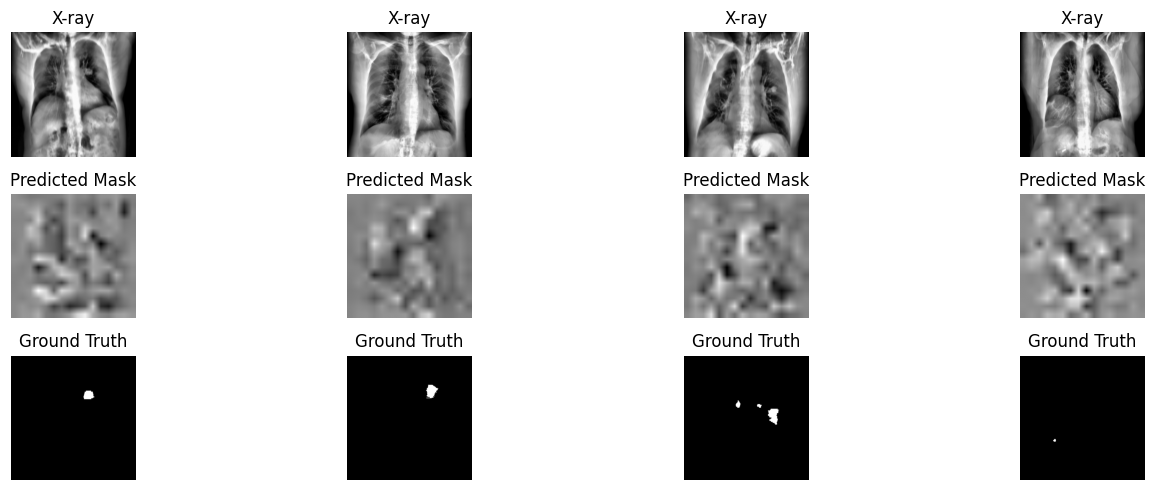

In [13]:
def show_prediction_vs_groundtruth(xrays, preds, masks, num=4):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(3, num, i+1)
        plt.imshow(xrays[i][0].cpu(), cmap='gray')
        plt.title("X-ray")
        plt.axis('off')

        plt.subplot(3, num, num+i+1)
        plt.imshow(preds[i][0].cpu(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(3, num, 2*num+i+1)
        plt.imshow(masks[i][0].cpu(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_prediction_vs_groundtruth(xray, pred_mask, mask)

Loss Function

In [14]:
def dice_loss(pred, target, eps=1e-7):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + eps) / (pred.sum() + target.sum() + eps)

In [15]:
# Hyperparameters
lambda_attn = 0.5  # weight for attention loss
num_epochs = 7

In [16]:
# Instantiate the model
model = XrayDRRSegmentationModel(pretrained_model, alpha=0.5)

# Move to device
model = model.to(device)

# Define optimizer for the trainable parameters in model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Set to training mode
model.train()

XrayDRRSegmentationModel(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

---- **Training Loop** ----

In [ ]:
for epoch in range(num_epochs):
    for batch in loader:
        xray = batch["xray"].to(device)      # [B, 1, 512, 512]
        drr = batch["drr"].to(device)        # [B, 1, 512, 512]
        mask = batch["mask"].to(device)      # [B, 1, 512, 512]

        optimizer.zero_grad()

        # Forward pass
        seg_out = model(xray, drr)           # [B, 1, 512, 512]

        # Supervised attention map (from DRR)
        with torch.no_grad():
            attn_map = model.attention_net(drr)  # Needed for loss_attn

        # Losses
        loss_task = dice_loss(seg_out, mask)
        loss_attn = F.binary_cross_entropy(attn_map, mask)
        loss_total = loss_task + lambda_attn * loss_attn

        # Backward and optimize
        loss_total.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss_total.item():.4f}")